<a href="https://colab.research.google.com/github/Sk8133/Explainable-AI/blob/main/E_AI_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

#  1) Input dataset (interpreting the last value as y=38 for x=2)
data = {
    'push_notifications': [1, 2, 3, 1, 2],
    'workout_sessions':    [25, 35, 42, 28, 38]
}
df = pd.DataFrame(data)

#  2) Baseline: mean of all workout sessions
baseline = df['workout_sessions'].mean()
print(f"Baseline (mean of y): {baseline:.4f}\n")

#  3) Fit linear regression (closed-form)
# Simple linear regression y = a + b*x
x = df['push_notifications'].values
y = df['workout_sessions'].values

# Closed-form (ordinary least squares) for slope (b) and intercept (a)
x_mean = x.mean()
y_mean = y.mean()

# slope b = sum((x - x_mean)*(y - y_mean)) / sum((x - x_mean)^2)
numerator = np.sum((x - x_mean) * (y - y_mean))
denominator = np.sum((x - x_mean)**2)
b_closed = numerator / denominator
a_closed = y_mean - b_closed * x_mean

print("Closed-form linear regression coefficients:")
print(f"  Intercept (a): {a_closed:.6f}")
print(f"  Slope     (b): {b_closed:.6f}\n")

#  4) Fit sklearn linear regression for sanity check
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
a_sklearn = model.intercept_
b_sklearn = model.coef_[0]

print("Sklearn linear regression coefficients (sanity check):")
print(f"  Intercept: {a_sklearn:.6f}")
print(f"  Slope    : {b_sklearn:.6f}\n")

# They should be essentially equal
assert np.isclose(a_closed, a_sklearn, atol=1e-8)
assert np.isclose(b_closed, b_sklearn, atol=1e-8)

#  5) Predictions, SHAP values, verification
df['predicted'] = a_closed + b_closed * df['push_notifications']
df['baseline'] = baseline
# SHAP value per the user's definition = predicted - baseline
df['shap_value'] = df['predicted'] - df['baseline']
# residual (actual - predicted) to detect under/over production
df['residual'] = df['workout_sessions'] - df['predicted']
df['over_under'] = df['residual'].apply(lambda r: 'underpredicted (actual > pred)' if r>0 else ('overpredicted (actual < pred)' if r<0 else 'exact'))

# verify Final Prediction = Baseline + SHAP Value for every row
df['verify_eq'] = np.isclose(df['predicted'], df['baseline'] + df['shap_value'])

#  6) Metrics
r2 = r2_score(df['workout_sessions'], df['predicted'])
mse = mean_squared_error(df['workout_sessions'], df['predicted'])
mae = mean_absolute_error(df['workout_sessions'], df['predicted'])

#  7) Present results neatly
pd.set_option('display.float_format', '{:.4f}'.format)
result_cols = ['push_notifications', 'workout_sessions', 'predicted', 'baseline', 'shap_value', 'residual', 'over_under', 'verify_eq']
print("Results table:")
print(df[result_cols].to_string(index=False))

print("\nModel performance:")
print(f"  R^2  : {r2:.4f}")
print(f"  MSE  : {mse:.4f}")
print(f"  MAE  : {mae:.4f}")

#  8) Row-by-row interpretation
print("\nRow-by-row interpretation:")
for i, row in df.iterrows():
    x_val = row['push_notifications']
    actual = row['workout_sessions']
    pred = row['predicted']
    shap = row['shap_value']
    residual = row['residual']
    note = row['over_under']
    influence = f"A positive SHAP ({shap:.3f}) means sending {x_val} notifications increases the predicted sessions above baseline."
    if shap < 0:
        influence = f"A negative SHAP ({shap:.3f}) means sending {x_val} notifications decreases the predicted sessions below baseline."
    print(f"Row {i+1}: x={x_val}, actual={actual}, predicted={pred:.3f}, baseline={baseline:.3f}, SHAP={shap:.3f} => {note}")
    print(f"         Influence: {influence}")
    if residual > 0:
        print(f"         Actual > Pred by {residual:.3f} => model underpredicted (possible extra factors increased workouts).")
    elif residual < 0:
        print(f"         Actual < Pred by {abs(residual):.3f} => model overpredicted (possible factors reduced workouts).")
    else:
        print(f"         Model prediction exactly matched actual.")
    print("")

Baseline (mean of y): 33.6000

Closed-form linear regression coefficients:
  Intercept (a): 19.071429
  Slope     (b): 8.071429

Sklearn linear regression coefficients (sanity check):
  Intercept: 19.071429
  Slope    : 8.071429

Results table:
 push_notifications  workout_sessions  predicted  baseline  shap_value  residual                     over_under  verify_eq
                  1                25    27.1429   33.6000     -6.4571   -2.1429  overpredicted (actual < pred)       True
                  2                35    35.2143   33.6000      1.6143   -0.2143  overpredicted (actual < pred)       True
                  3                42    43.2857   33.6000      9.6857   -1.2857  overpredicted (actual < pred)       True
                  1                28    27.1429   33.6000     -6.4571    0.8571 underpredicted (actual > pred)       True
                  2                38    35.2143   33.6000      1.6143    2.7857 underpredicted (actual > pred)       True

Model performanc

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Step 1: Create the dataset
data = {
    "Gym_Collabs": [2, 1, 3, 0, 2],
    "Influencer_Posts": [5, 3, 4, 2, 1],
    "Awareness_Score": [70, 55, 80, 40, 50]
}
df = pd.DataFrame(data)

# Step 2: Define independent and dependent variables
X = df[["Gym_Collabs", "Influencer_Posts"]]
y = df["Awareness_Score"]

# Step 3: Fit Multiple Linear Regression
model = LinearRegression()
model.fit(X, y)

# Step 4: Get coefficients and intercept
coef_gym, coef_influencer = model.coef_
intercept = model.intercept_

print("Model Coefficients:")
print(f"Gym Collabs Coefficient: {coef_gym:.2f}")
print(f"Influencer Posts Coefficient: {coef_influencer:.2f}")
print(f"Intercept: {intercept:.2f}")

# Step 5: Calculate Baseline Value (mean of y)
baseline_value = np.mean(y)
print(f"\nBaseline (Mean Awareness Score): {baseline_value:.2f}")

# Step 6: Calculate SHAP Values for each record
# SHAP = (feature_value - mean_feature_value) * coefficient
mean_gym = np.mean(df["Gym_Collabs"])
mean_influencer = np.mean(df["Influencer_Posts"])

df["SHAP_Gym"] = (df["Gym_Collabs"] - mean_gym) * coef_gym
df["SHAP_Influencer"] = (df["Influencer_Posts"] - mean_influencer) * coef_influencer

# Step 7: Compute final predictions
df["Prediction"] = baseline_value + df["SHAP_Gym"] + df["SHAP_Influencer"]

# Step 8: Verification
df["Check"] = np.isclose(df["Prediction"], model.predict(X))

# Step 9: Interpretation
interpretations = []
for i, row in df.iterrows():
    actual = row["Awareness_Score"]
    pred = row["Prediction"]
    shap_g = row["SHAP_Gym"]
    shap_i = row["SHAP_Influencer"]

    direction = "overpredicted" if pred > actual else "underpredicted"

    interp = (
        f"Record {i+1}: Gym Collabs contributed {shap_g:.2f} points, "
        f"Influencer Posts contributed {shap_i:.2f} points. "
        f"Predicted = {pred:.2f}, Actual = {actual}, so the model {direction}."
    )
    interpretations.append(interp)

# Step 10: Print results
print("\nFinal Data with SHAP Values:")
print(df[["Gym_Collabs", "Influencer_Posts", "Awareness_Score",
          "SHAP_Gym", "SHAP_Influencer", "Prediction", "Check"]])

print("\nInterpretations:")
for line in interpretations:
    print(line)

Model Coefficients:
Gym Collabs Coefficient: 9.07
Influencer Posts Coefficient: 5.28
Intercept: 28.65

Baseline (Mean Awareness Score): 59.00

Final Data with SHAP Values:
   Gym_Collabs  Influencer_Posts  Awareness_Score  SHAP_Gym  SHAP_Influencer  \
0            2                 5               70    3.6279          10.5581   
1            1                 3               55   -5.4419           0.0000   
2            3                 4               80   12.6977           5.2791   
3            0                 2               40  -14.5116          -5.2791   
4            2                 1               50    3.6279         -10.5581   

   Prediction  Check  
0     73.1860   True  
1     53.5581   True  
2     76.9767   True  
3     39.2093   True  
4     52.0698   True  

Interpretations:
Record 1: Gym Collabs contributed 3.63 points, Influencer Posts contributed 10.56 points. Predicted = 73.19, Actual = 70, so the model overpredicted.
Record 2: Gym Collabs contributed -5.44 p

Baseline (mean target on train): 153.737
Sample 0
  Model prediction:      139.548
  Baseline + SHAP sum:   143.335
  Difference (error):    -3.787e+00

--- Record 0 ---
Predicted = 139.548, Actual = 219.000
Feature contributions (SHAP values):
s2    64.5872
s5    23.6913
sex   10.3790
s4     9.3874
s3     3.5618
dtype: float64
s1    -116.4154
bp      -3.6831
bmi     -3.3617
s6      -0.5100
age      1.9621
dtype: float64
→ Model underpredicted.

--- Record 1 ---
Predicted = 179.517, Actual = 70.000
Feature contributions (SHAP values):
s1    23.2882
bmi   20.0238
sex   10.3790
bp     9.4849
age    3.7520
dtype: float64
s5   -16.7620
s4   -10.9317
s2    -8.9032
s6    -1.3164
s3     0.5535
dtype: float64
→ Model overpredicted.

--- Record 2 ---
Predicted = 134.039, Actual = 202.000
Feature contributions (SHAP values):
s5    62.0172
s2    25.0030
s3     9.5783
age    2.6505
s4    -0.7721
dtype: float64
s1    -95.9085
sex   -12.6855
bp     -2.4860
bmi    -2.1924
s6     -1.1148
dtype: float6

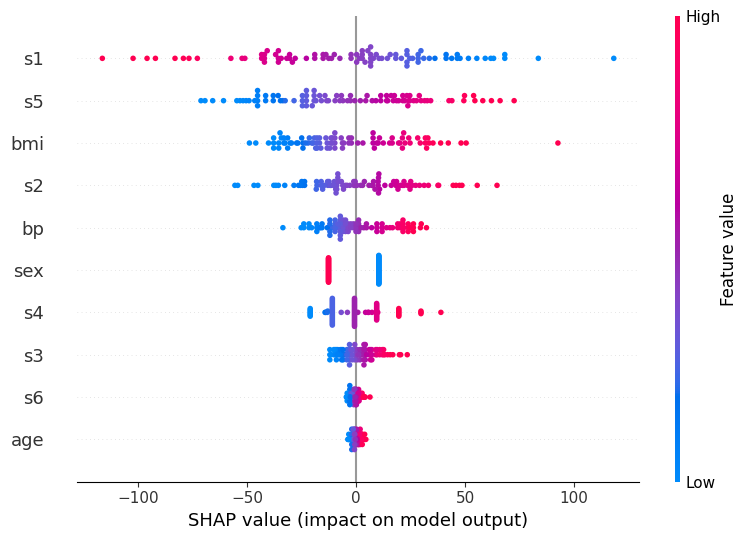

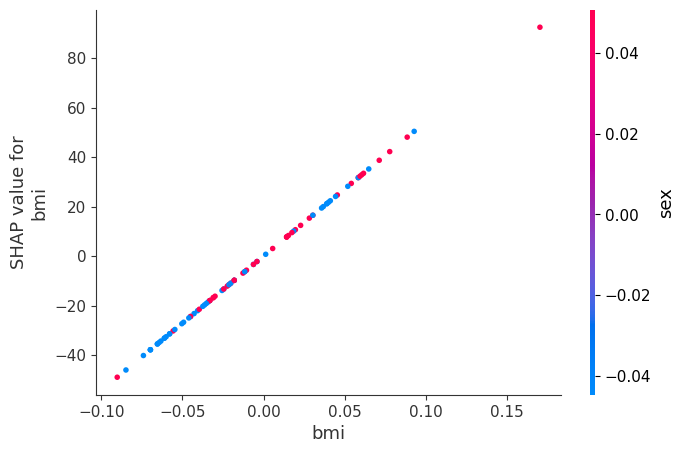

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import shap
# 1. Load data
X, y = load_diabetes(return_X_y=True, as_frame=True)
# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# 3. Fit multiple linear regression
model = LinearRegression()
model.fit(X_train, y_train)
# 4. Baseline value (mean of training target)
baseline = y_train.mean()
print(f"Baseline (mean target on train): {baseline:.3f}")
# 5. Compute SHAP values using linear model explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
# 6. Validate prediction decomposition for the first test sample
i = 0
pred = model.predict(X_test.iloc[[i]])[0]
shap_sum = shap_values.values[i].sum()
reconstructed = baseline + shap_sum
print("Sample", i)
print(f"  Model prediction:      {pred:.3f}")
print(f"  Baseline + SHAP sum:   {reconstructed:.3f}")
print(f"  Difference (error):    {pred - reconstructed:.3e}")
# 7. Interpret each test record
for idx in range(len(X_test)):
    pred_val = model.predict(X_test.iloc[[idx]])[0]
    actual_val = y_test.iloc[idx]
    shap_contribs = pd.Series(shap_values.values[idx], index=X_test.columns)
    print(f"\n--- Record {idx} ---")
    print(f"Predicted = {pred_val:.3f}, Actual = {actual_val:.3f}")
    print("Feature contributions (SHAP values):")
    print(shap_contribs.sort_values(ascending=False).head(5))
    print(shap_contribs.sort_values().head(5))
    if pred_val > actual_val:
        print("→ Model overpredicted.")
    elif pred_val < actual_val:
        print("→ Model underpredicted.")
    else:
        print("→ Perfect prediction.")
# Optional: visualize global summary
shap.summary_plot(shap_values.values, X_test)
# Optional: dependence plot for a specific feature, e.g., 'bmi'
shap.dependence_plot("bmi", shap_values.values, X_test)

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset with correct separator
df = pd.read_csv("/content/sample_data/student-mat.csv", sep=";")  # UCI dataset uses semicolon as delimiter

# Show all column names to debug
print("Column names in the dataset:")
print(df.columns.tolist())

# Encode categorical variables
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include='object'):
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# Check if 'G3' exists
if 'G3' not in df_encoded.columns:
    raise ValueError("Column 'G3' (final grade) not found in the dataset.")

# Split features and target
X = df_encoded.drop('G3', axis=1)
y = df_encoded['G3']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_data/student-mat.csv'

In [8]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [9]:
baseline_value = y_train.mean()
print(f"Baseline value (mean of final exam scores): {baseline_value}")

Baseline value (mean of final exam scores): 153.73654390934846


In [10]:
import shap

# SHAP initialization
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

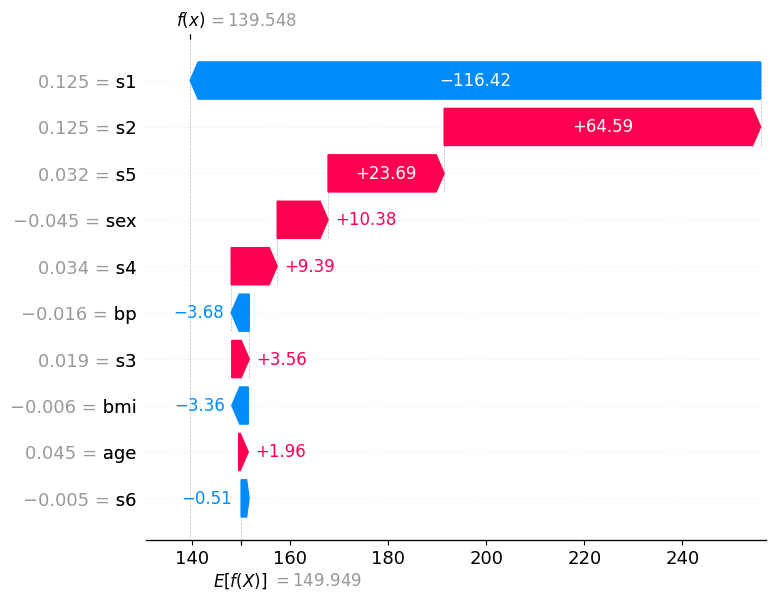

In [11]:
# Print SHAP summary for a single instance
shap.plots.waterfall(shap_values[0])